<a href="https://colab.research.google.com/github/EdnaEze/Text-Classifier/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

# Import Libraries

In [2]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Load Dataset

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/Deep Learning/tripadvisor_hotel_reviews.csv')
dataset.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [5]:
dataset['Rating'].nunique()

5

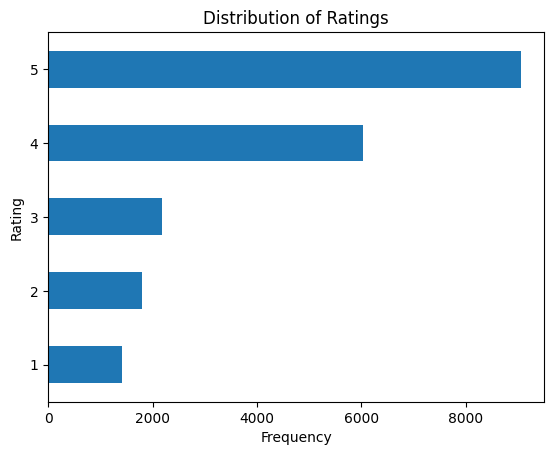

In [6]:
dataset["Rating"].value_counts(ascending=True).plot.barh()
plt.title("Distribution of Ratings")
plt.xlabel("Frequency")
plt.ylabel("Rating")
plt.show()

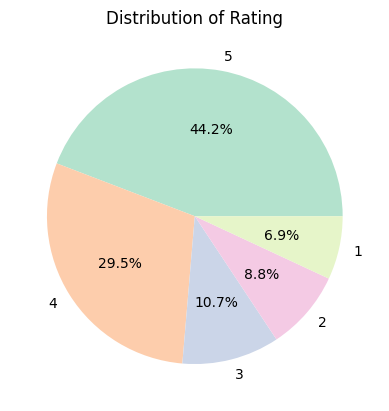

In [7]:
# Count the occurrences of each label
Rating_counts = dataset['Rating'].value_counts()
# Create a pie chart
plt.pie(Rating_counts, labels=Rating_counts.index, colors = plt.cm.Pastel2.colors, autopct='%1.1f%%')
plt.title('Distribution of Rating')
plt.show()


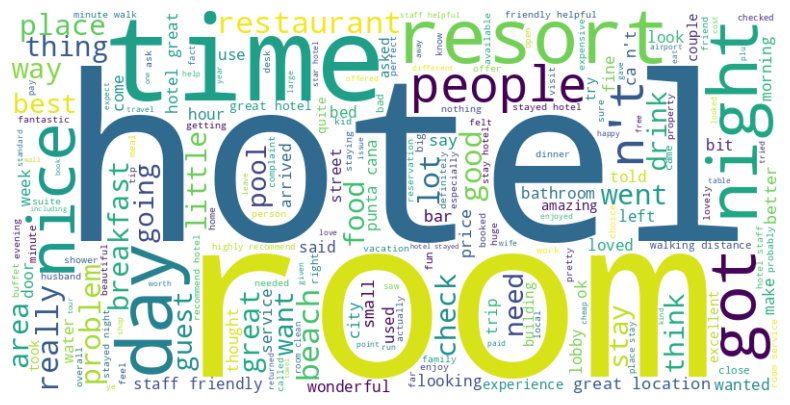

In [8]:
# Join all reviews into a single string
all_reviews = ' '.join(dataset['Review'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, prefer_horizontal=0.3, background_color='white', stopwords=STOPWORDS).generate(all_reviews)

# Display the image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Lenght of Reviews

Transformer models have a maximum input sequence length that is referred to as the **maximum context size**. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text.

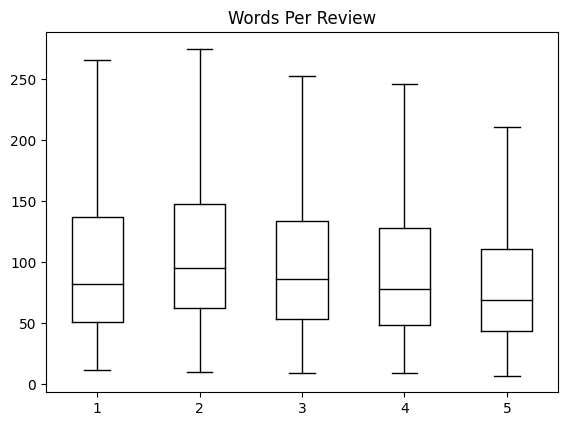

In [9]:
dataset["Words Per Review"] = dataset["Review"].str.split().apply(len)
dataset.boxplot("Words Per Review", by="Rating", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

From the plot we see that for each Rating most reviews are around 80 words long and the longest reviews are well below DistilBERT's maximum context size. Texts that are longer than a model's context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information; in this case, it looks like that won't be an issue.

In [10]:
dataset = dataset.drop(['Words Per Review'], axis=1)
dataset.head(3)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3


# Tokenization

Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model. There are several tokenization strategies one can adopt, and the optimal splitting of words into subunits is usually learned from the corpus.

In [11]:
# First convert pandas dataframe to Hugging face dataset object
dataset = Dataset.from_pandas(dataset)

In [12]:
dataset

Dataset({
    features: ['Review', 'Rating'],
    num_rows: 20491
})

In [13]:
df = dataset.train_test_split(test_size=0.2)
df

DatasetDict({
    train: Dataset({
        features: ['Review', 'Rating'],
        num_rows: 16392
    })
    test: Dataset({
        features: ['Review', 'Rating'],
        num_rows: 4099
    })
})

### Subword Tokenization

The function below applies the tokenizer to a batch of examples; padding=True will pad the examples with zeros to the size of the longest one in a batch, and truncation=True will truncate the examples to the model's maximum context size. To see tokenize()

In [14]:
# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define a function to tokenize and preprocess the text
def tokenize(batch):
    # Tokenize the text using the tokenizer
    return tokenizer(batch["Review"], truncation=True, padding='max_length', max_length=512)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [15]:
# Apply the preprocessing function across all splits in the dataset
tokenized_dataset = df.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16392 [00:00<?, ? examples/s]

Map:   0%|          | 0/4099 [00:00<?, ? examples/s]

In [16]:
print(tokenized_dataset["train"].column_names)

['Review', 'Rating', 'input_ids', 'attention_mask']


# Training the Text Classifier

### Load the weights of Pretrained model

In [17]:
# Specify the model checkpoint
model_ckpt = "distilbert-base-uncased"

# Determine if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the DistilBERT model and move it to the selected device
model = DistilBertModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

### Extract hidden state

In [18]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [19]:
#Convert input_ids and attention_mask to torch format(tensors)

tokenized_dataset.set_format("torch",
                            columns=["input_ids", "attention_mask", "Rating"])

In [22]:
#Extract all hidden states across all splits

df_hidden = tokenized_dataset.map(extract_hidden_states, batched=True, batch_size=32)

Map:   0%|          | 0/16392 [00:00<?, ? examples/s]

Map:   0%|          | 0/4099 [00:00<?, ? examples/s]

In [23]:
df_hidden["train"].column_names

['Review', 'Rating', 'input_ids', 'attention_mask', 'hidden_state']

## Creating a feature matrix

In [26]:
import numpy as np

X_train = np.array(df_hidden["train"]["hidden_state"])
X_test = np.array(df_hidden["test"]["hidden_state"])
y_train = np.array(df_hidden["train"]["Review"])
y_test = np.array(df_hidden["test"]["Review"])
X_train.shape, X_test.shape

((16392, 768), (4099, 768))

## Training a simple classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

In [ ]:
lr_clf.score(X_test, y_test)

### Compare to a dummy classifier

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

### Investigate performance with confusion matrix

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_test)
plot_confusion_matrix(y_preds, y_valid, labels)